In [2]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## import data:

In [3]:
stock = pd.read_csv('stock_data_august_sorted.csv')

## take a look at the first 5 rows of data:

In [4]:
stock.head()

,Date,DateTime,Open,High,Low,Close,Volume
0,8/2/2021 1:30:32 PM,1627911032404,358.810,358.905,358.3100,358.9050,53708
1,8/2/2021 1:31:32 PM,1627911092586,358.890,359.120,357.9850,358.0001,92260
2,8/2/2021 1:32:32 PM,1627911152671,357.960,358.180,357.2500,357.7000,54601
3,8/2/2021 1:33:33 PM,1627911213742,357.730,357.890,357.2300,357.5300,63468
4,8/2/2021 1:34:34 PM,1627911274303,357.555,357.660,357.2109,357.2400,41336


## check the dataframe info:

In [5]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7841 entries, 0 to 7840
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      7841 non-null   object 
 1   DateTime  7841 non-null   int64  
 2   Open      7841 non-null   float64
 3   High      7841 non-null   float64
 4   Low       7841 non-null   float64
 5   Close     7841 non-null   float64
 6   Volume    7841 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 428.9+ KB


## Time Series Data Prep:

### 1. make "Date" column as the index
### 2. select "Open" as our time series data to predict the open price for FB

In [6]:
# make the column "Date" become datetime object
stock['Date'] = pd.to_datetime(stock['Date'])

# set "Date" column as the index
stock.set_index('Date', inplace=True)

# set "Open" column as the time series data
x = stock[['Open']]
x


,Open
Date,
2021-08-02 13:30:32,358.810
2021-08-02 13:31:32,358.890
2021-08-02 13:32:32,357.960
2021-08-02 13:33:33,357.730
2021-08-02 13:34:34,357.555
...,...
2021-08-30 19:55:47,380.685
2021-08-30 19:56:48,380.770
2021-08-30 19:57:48,380.870


## check the trend & seasonality of time series data

<AxesSubplot:xlabel='Date'>

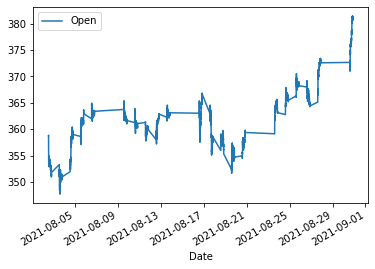

In [7]:
x.plot()

In [8]:
# take the rolling mean to see the trend:

roll_means = x.rolling(window = 1000).mean()

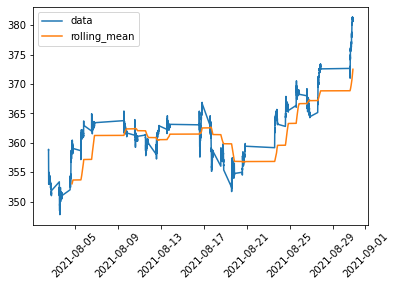

In [9]:
fig, ax = plt.subplots()
ax.plot(x, label = 'data')
ax.plot(roll_means, label = 'rolling_mean')
ax.tick_params('x', rotation = 45)
ax.legend();

## conclusion:

## => there is a trend near late August
## => no obvious seasonality

## using Augmented Dickey-Fuller test to check if the data is stationary or not

In [10]:
# obtain the p-value from adfuller test:

adfuller(x.Open)[1]

0.9741659953723604

In [11]:
# the p-value above is > 0.05, our goal is to get p-value < 0.05:
# so let's take the first level of difference on our data:

adfuller(x.Open.diff().dropna())[1]

0.0

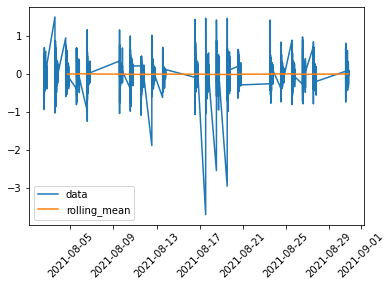

In [12]:
fig, ax = plt.subplots()
ax.plot(x.Open.diff(), label = 'data') 
ax.plot(x.Open.diff().rolling(window=1000).mean(), label = 'rolling_mean')
ax.tick_params('x', rotation = 45)
ax.legend();

## conclusion:

## => after taking the 1st level of difference, the rolling mean looks stationary
## => so later the "D" value of (P, D, Q) for hyperparameter tuning for  ARIMA model will start from 1

## checking what might be the good values for P & Q in ARIMA model

## using autocorrelation function to reference the "Q" in ARIMA model
## using partial autocorrelation function to reference the "P" in ARIMA model

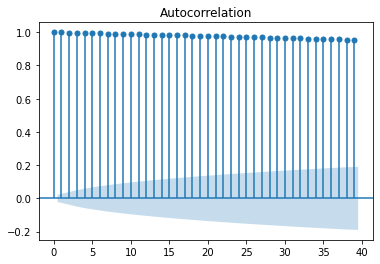

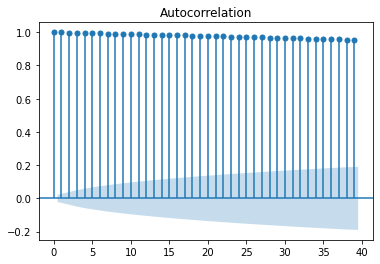

In [13]:
# plot the autocorrelation function:

plot_acf(x)

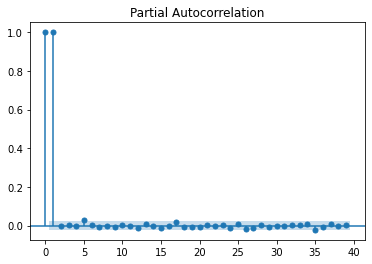

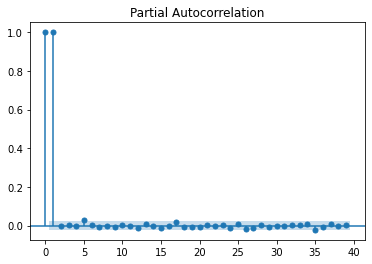

In [14]:
# plot the partial autocorrelation function:

plot_pacf(x) 

## conclusion:

## => from autocorrelation function, we can not see what would be the good value for Q
## => from partial autocorrelation function, we can see "2" might be the good value for P


## Overall, we still need to do hyperparameters tuining for (P, D, Q) to see what permutation of (P, D, Q) yields the
## best RMSE

# train & test split:

## here I'll choose the bottom 50 rows of data as my test dataset for computer power constrain

In [15]:
train = x.iloc[:-50]
test = x.iloc[-50:]

In [16]:
# take a look at our train 
train

,Open
Date,
2021-08-02 13:30:32,358.8100
2021-08-02 13:31:32,358.8900
2021-08-02 13:32:32,357.9600
2021-08-02 13:33:33,357.7300
2021-08-02 13:34:34,357.5550
...,...
2021-08-30 19:04:18,381.1600
2021-08-30 19:05:19,381.1750
2021-08-30 19:06:20,381.1650


In [17]:
# take a look at our test:

test

,Open
Date,
2021-08-30 19:09:22,381.1200
2021-08-30 19:10:27,381.1823
2021-08-30 19:11:33,381.2070
2021-08-30 19:12:40,381.1700
2021-08-30 19:13:43,381.1300
2021-08-30 19:14:44,381.1900
2021-08-30 19:15:48,381.3300
2021-08-30 19:16:51,381.3599
2021-08-30 19:17:52,381.3701


## taking log1p transform for the stock price to flatten the fluctuation:

In [18]:
train_1 = np.log1p(train)
test_1 = np.log1p(test)

In [19]:
# take a look at train_1:

train_1

,Open
Date,
2021-08-02 13:30:32,5.885576
2021-08-02 13:31:32,5.885798
2021-08-02 13:32:32,5.883211
2021-08-02 13:33:33,5.882570
2021-08-02 13:34:34,5.882082
...,...
2021-08-30 19:04:18,5.945839
2021-08-30 19:05:19,5.945879
2021-08-30 19:06:20,5.945852


In [20]:
# take a look at test_1:

test_1

,Open
Date,
2021-08-30 19:09:22,5.945735
2021-08-30 19:10:27,5.945898
2021-08-30 19:11:33,5.945962
2021-08-30 19:12:40,5.945866
2021-08-30 19:13:43,5.945761
2021-08-30 19:14:44,5.945918
2021-08-30 19:15:48,5.946284
2021-08-30 19:16:51,5.946362
2021-08-30 19:17:52,5.946389


## get the permutation of (P, D, Q) for ARIMA:

In [21]:
p = range(1, 7)
d = range(1, 3)
q = range(3)
params = list(itertools.product(p, d, q))
params

[(1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 2, 0),
 (4, 2, 1),
 (4, 2, 2),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 2, 0),
 (5, 2, 1),
 (5, 2, 2),
 (6, 1, 0),
 (6, 1, 1),
 (6, 1, 2),
 (6, 2, 0),
 (6, 2, 1),
 (6, 2, 2)]

## a function for ARIMA model training:

In [22]:
def training(i, xtrain, xtest):
    """This function is for ARIMA model training.

    Parameters
    ----------
    i : tuple
        the (P, D, Q) combination
    xtrain : pandas series
        the training series 
    xtest : pandas series
        the test series

    Returns
    -------
    prediction, list
        a list of prediction
    """
    try:
        prediction = []
        
        for j in range(len(xtest)):
            try:
                model = ARIMA(xtrain, order = i).fit()
                pred = model.forecast()[0]
                prediction.append(pred)
                xtrain = xtrain.append(pd.Series(xtest.iloc[j]), ignore_index = True)
                
            except:
                prediction.append(np.nan)
        
        return prediction
    
    except Exception as err:
        print(err) 

## a fucntion for calculating the RMSE:

In [23]:
def rmse_calculation(params, train_org, test):
    """This function is for ARIMA model training & get a list of RMSE of each
    permutation of (P, D, Q)

    Parameters
    ----------
    params : list
        a list of (P, D, Q) permutation
    train_org : pandas series
        the training series
    test : pandas series
        the test series

    Returns
    -------
    rmse_box, list
        a list of RMSE from ARIMA model training with each (P, D, Q) permutation
    """
    try:
        rmse_box = []
        for i in params:
            try:
                train = train_org.copy()
                prediction = training(i, train, test)
                rmse = np.sqrt(
                    mean_squared_error(np.expm1(test), np.expm1(prediction))
                    )
                rmse_box.append(rmse)
                print(f"(P, D, Q): {i}, RMSE: {rmse}")
            except:
                rmse_box.append(np.nan)
                print(f"(P, D, Q): {i}, RMSE: nan")
        
        print(f"smallest RMSE: {min(rmse_box)}, \
        (P, D, Q) = {params[rmse_box.index(min(rmse_box))]}.") 
        
        return rmse_box
    
    except Exception as err:
        print(err) 

In [24]:
rmse_lst = rmse_calculation(params, train_1, test_1) 

(P, D, Q): (1, 1, 0), RMSE: 0.11360557486116646
(P, D, Q): (1, 1, 1), RMSE: nan
(P, D, Q): (1, 1, 2), RMSE: nan
(P, D, Q): (1, 2, 0), RMSE: 0.13835937016876426
(P, D, Q): (1, 2, 1), RMSE: 0.11569604151263282
(P, D, Q): (1, 2, 2), RMSE: 0.11679054709840693
(P, D, Q): (2, 1, 0), RMSE: 0.11359077915882478
(P, D, Q): (2, 1, 1), RMSE: 0.11358793389949665
(P, D, Q): (2, 1, 2), RMSE: nan
(P, D, Q): (2, 2, 0), RMSE: 0.1376532732285943
(P, D, Q): (2, 2, 1), RMSE: 0.1167125300964314
(P, D, Q): (2, 2, 2), RMSE: 0.11590946026057664
(P, D, Q): (3, 1, 0), RMSE: 0.11379204557160905
(P, D, Q): (3, 1, 1), RMSE: 0.11379258439087815
(P, D, Q): (3, 1, 2), RMSE: 0.11320040374388404
(P, D, Q): (3, 2, 0), RMSE: 0.13010935972611584
(P, D, Q): (3, 2, 1), RMSE: 0.11723281263063558
(P, D, Q): (3, 2, 2), RMSE: 0.11537163216871722
(P, D, Q): (4, 1, 0), RMSE: 0.11422518843715138
(P, D, Q): (4, 1, 1), RMSE: 0.11404742983029045
(P, D, Q): (4, 1, 2), RMSE: 0.11399215708031235
(P, D, Q): (4, 2, 0), RMSE: 0.128124104761

## from the hyperparameter tuning result above, train the whole dataset with the best (P, D, Q) to 
## get the final model

In [27]:
final_model = ARIMA(x, order = (3, 1, 2)).fit()

## get prediction for the open price on Aug. 31:

In [46]:
pred = final_model.forecast()[0]
pred

array([380.83118754])

## calculate the error between prediction & actual value:

In [54]:
actual_open_price = 379.950012

error = float(np.round_(abs(actual_open_price - pred), 2))
print(f"The error for FB stock open price on Aug. 31 is ${error} dollars.")

The error for FB stock open price on Aug. 31 is $0.88 dollars.
